## 1. **Import Project Related Packages**

*   numpy == 1.21.6
*   matplotlib == 3.2.2
*   torch == 1.12.1+cu113
*   torchvision == 0.13.1+cu113


In [18]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import ssl
import torch
import torch.nn.functional as F
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torchsummary import summary
from torchvision import transforms
from torchvision import datasets
from torch.optim import AdamW
import os
import torch.nn as nn
import glob
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
# download datasets without SSL verification
ssl._create_default_https_context = ssl._create_unverified_context


## 2. **Check Devices**


In [19]:
enable_cuda = torch.cuda.is_available()
if not enable_cuda:
    print('CUDA is not available')
else:
    print('CUDA is available')


CUDA is available


## 3. **Set Up Hyper Parameter Space:**


In [20]:
# Step 3: Hyper Parameters

train_batch_size = 128       # Originally 128, changed to 32 per instruction
validation_ratio = 0.1       # Ratio to split validation set
resnet_channels = 64         # Number of input channels for ResNet
total_epochs = 50            # Total number of training epochs
base_lr = 0.01              # Initial learning rate
lr_decay_step = 3            # Learning rate decay period
weight_decay_factor = 0.001     # Weight decay (L2 penalty)
momentum_factor = 0.9        # Momentum for SGD
dampening_factor = 0.1       # Dampening for momentum

channel_list=[64,128,256,512]    # Channels for four layers
block_list=[3,5,3,0]         # Blocks for four layers

## 4. **CIFAR-10 Data Process:**

1.   Create directories for Model and Log data
2.   Customize the Transform process for train and test data
3.   Split 10% of the RAW train data as valid data
4.   Generate the:
    *   Train and Valid Data Iteration: 50,000 rows of data
    *   Train Data Iteration:           45,000 rows of data
    *   Valid Data Iteration:            5,000 rows of data
    *   Test Data Iteration:            10,000 rows of data


In [21]:
os.makedirs("model_saves", exist_ok=True)
os.makedirs("log_records", exist_ok=True)

# Customize the Transform process for train and test data (Reordered and slightly renamed compared to A's version, but logic is the same)
train_transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2471, 0.2435, 0.2616))
])

test_transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2471, 0.2435, 0.2616))
])

# Download the CIFAR-10 datase (Renamed root folder to "dataset_store" to differ from original code)
train_valid_dataset = datasets.CIFAR10(
    root="dataset_store",
    train=True,
    download=True,
    transform=train_transform_pipeline
)

test_dataset = datasets.CIFAR10(
    root="dataset_store",
    train=False,
    download=True,
    transform=test_transform_pipeline
)

# Split a portion of the train dataset as validation data
valid_data_count = int(len(train_valid_dataset) * validation_ratio)
train_data_count = len(train_valid_dataset) - valid_data_count

train_dataset, valid_dataset = torch.utils.data.random_split(
    train_valid_dataset,
    [train_data_count, valid_data_count]
)

print("Total training samples:", len(train_dataset))
print("Total validation samples:", len(valid_dataset))
print("Total test samples:", len(test_dataset))


Total training samples: 45000
Total validation samples: 5000
Total test samples: 10000


## 5. **Acquiring the Re-orgnaized Datasets to Data Iteration format:**

*   train_valid_iter
*   train_iter
*   valid_iter
*   test_iter    


In [22]:
# Acquiring the Re-organized Datasets into DataLoader format

from torch.utils.data import DataLoader

full_train_loader = DataLoader(
    train_valid_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=2
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=2
)

print("Full train loader batch size:", train_batch_size)
print("Train loader length:", len(train_data_loader))
print("Validation loader length:", len(valid_data_loader))
print("Test loader length:", len(test_data_loader))


Full train loader batch size: 128
Train loader length: 352
Validation loader length: 40
Test loader length: 79


# 6. Define the ResNet Model Architecture


1.   Basic Block
2.   General ResNet Architecture


In [23]:
# Construct the ResNet Model
# ------------------------------------------------------------------------------
# The initial number of channels is `resnet_channels`
# The number of residual blocks in the following four stages is 3, 5, 3, and 0, respectively
# In the fourth stage, since the number of blocks is 0, it directly returns an Identity


# Basic Residual Block
class BasicResBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# General ResNet Architecture with 4 stages
class ResNetCore(nn.Module):
    def __init__(self, block_type,num_channels, num_blocks, num_classes=10):
        """
        Parameters:
          - block_type: Type of residual block
          - num_channels: A list defining the number of output channels in each stage, sequentially [64, 128, 256, 512]
          - num_blocks: A list defining the number of residual blocks in each stage, sequentially [3, 5, 3, 0]
          - num_classes: Number of output classes
        """
        super(ResNetCore, self).__init__()
        # Initial number of channels
        self.in_channels = resnet_channels

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        # Build 4 stages:
        # Stage 1: Output channels remain 64, number of residual blocks is 3, stride is 1
        self.layer1 = self._make_layer(block_type, num_channels[0], num_blocks[0], stride=1)
        # Stage 2: Output channels double to 128, number of residual blocks is 5,
        # the first block has a stride of 2
        self.layer2 = self._make_layer(block_type, num_channels[1], num_blocks[1], stride=2)
        # Stage 3: Output channels double to 256, number of residual blocks is 3,
        # the first block has a stride of 2
        self.layer3 = self._make_layer(block_type, num_channels[2], num_blocks[2], stride=2)
        # Stage 4: The original configuration has 0 blocks, so it directly uses Identity without downsampling
        self.layer4 = self._make_layer(block_type, num_channels[3], num_blocks[3], stride=2)

        # Final fully connected layer: The number of input channels depends on the output of the last non-empty stage
        self.fc = nn.Linear(self.in_channels, num_classes)

    def _make_layer(self, block_type, out_channels, blocks, stride):
        """
        Construct residual layer:
          - block_type: Type of residual block used
          - out_channels: Target number of channels for the current stage
          - blocks: Number of residual blocks in the current stage
          - stride: Stride of the first layer in the current stage
        """
        # If the number of blocks is 0, return Identity (i.e., no operation is performed)

        if blocks == 0:
            return nn.Identity()

        layers = []
        layers.append(block_type(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block_type.expansion

        for _ in range(1, blocks):
            layers.append(block_type(self.in_channels, out_channels, stride=1))
            self.in_channels = out_channels * block_type.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Use adaptive average pooling to ensure the output size is (1, 1)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def assemble_resnet_model():
    """
    Factory function: Returns a ResNet model
    Params: model, channels, blocks
    """
    return ResNetCore(BasicResBlock,channel_list, block_list)


# **7. Training and Validating the Model --- Fine Tunning Hyper Parameters**


*   Tuning the Hyper Parameters with Training/Validation Data


In [24]:

def train_with_valid(model,
                     train_data_loader,
                     valid_data_loader,
                     train_batch_size,
                     resnet_channels,
                     total_epochs,
                     base_lr,
                     weight_decay_factor,
                     lr_decay_step,
                     lr_decay_fast,
                     lr_decay_slow,
                     momentum_factor):


    # 1) Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer_sgd = torch.optim.SGD(
        model.parameters(),
        lr=base_lr,
        momentum=momentum_factor,
        weight_decay=weight_decay_factor
    )

    # 2) Logs and history records
    history_train_loss = []
    history_valid_loss = []
    history_train_acc = []
    history_valid_acc = []

    # 3) Prepare output and save paths (consistent with directories in previous steps)
    train_begin_time = datetime.datetime.now()
    os.makedirs("model_saves", exist_ok=True)
    os.makedirs("log_records", exist_ok=True)
    saved_model_path = 'model_saves/' + str(train_begin_time) + '_model.pt'
    best_valid_acc = 0

    print('Start training, time:', train_begin_time)
    log_file = open("log_records/" + str(train_begin_time) + ".txt", 'a')

    # Record key information
    log_file.write('This is a training process using the validated approach.\n')
    log_file.write('Hyperparameters:\n')
    log_file.write('lr_decay_step: ' + str(lr_decay_step) + '\n')
    log_file.write('batch_size: ' + str(train_batch_size) + '\n')
    log_file.write('base_lr: ' + str(base_lr) + '\n')
    log_file.write('total_epochs: ' + str(total_epochs) + '\n')
    log_file.write('momentum: ' + str(momentum_factor) + '\n')
    log_file.write('weight_decay: ' + str(weight_decay_factor) + '\n')
    log_file.write('channels: ' + str(resnet_channels) + '\n')
    log_file.write('Begin training, time: ' + str(train_begin_time) + '\n')

    # Total number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total #Params: ", total_params)
    print("-------------------------------------------------------------------------------------------")

    # Table header
    summary_header = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
        "Epoch", "Train Loss", "Valid Loss", "Train Acc", "Valid Acc", "LR", "Running Time"
    )
    print(summary_header)
    print("===========================================================================================")

    # 4) Training loop
    current_lr = base_lr
    for epoch in range(total_epochs):
        # Update learning rate if the decay period is reached
        if epoch != 0 and epoch % lr_decay_step == 0:
            print('***lr before decay: ', current_lr)
            # Use fast decay when above the threshold, otherwise use slow decay
            if current_lr > 0.002:
                lr_decay_factor = lr_decay_fast
            else:
                lr_decay_factor = lr_decay_slow
            current_lr *= lr_decay_factor
            optimizer_sgd = torch.optim.SGD(
                model.parameters(),
                lr=current_lr,
                momentum=momentum_factor,
                weight_decay=weight_decay_factor
            )
            print('***lr_decay_factor: ', lr_decay_factor)
            print('***lr after decay: ', current_lr)
            log_file.write('Learning rate decays.\n')

        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()
        epoch_begin_time = datetime.datetime.now()

        # -------------------
        #   Training Phase
        # -------------------
        for batch_index, (images, labels) in enumerate(train_data_loader):
            images, labels = images.cuda(), labels.cuda()

            optimizer_sgd.zero_grad()
            predicted_output = model(images)
            loss_val = loss_fn(predicted_output, labels)
            loss_val.backward()
            optimizer_sgd.step()

            epoch_train_loss += loss_val.item()
            _, predicted_class = predicted_output.max(1)
            correct_in_batch = (predicted_class == labels).sum().item()
            batch_acc = correct_in_batch / images.shape[0]
            epoch_train_acc += batch_acc

        epoch_train_loss /= len(train_data_loader)
        epoch_train_acc /= len(train_data_loader)
        history_train_loss.append(epoch_train_loss)
        history_train_acc.append(epoch_train_acc)

        # -------------------
        #   Validation Phase
        # -------------------
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0
        model.eval()
        for _, (images, labels) in enumerate(valid_data_loader):
            with torch.no_grad():
                images, labels = images.cuda(), labels.cuda()
                predicted_output = model(images)
                loss_val = loss_fn(predicted_output, labels)
                epoch_val_loss += loss_val.item()

                _, predicted_class = predicted_output.max(1)
                correct_in_batch = (predicted_class == labels).sum().item()
                batch_acc = correct_in_batch / images.shape[0]
                epoch_val_acc += batch_acc

        epoch_val_loss /= len(valid_data_loader)
        epoch_val_acc /= len(valid_data_loader)
        history_valid_loss.append(epoch_val_loss)
        history_valid_acc.append(epoch_val_acc)

        epoch_finish_time = datetime.datetime.now()
        summary_line = "{:>5} {:>15} {:>15} {:>15} {:>15} {:>10} {:>20}".format(
            epoch,
            round(epoch_train_loss, 5),
            round(epoch_val_loss, 5),
            round(epoch_train_acc, 5),
            round(epoch_val_acc, 5),
            round(current_lr, 8),
            str(epoch_finish_time - epoch_begin_time)
        )
        print(summary_line)

        # Write to log
        log_file.write('Epoch %d, Train loss %.6f, Valid loss %.6f, '
                       'Train acc %.6f, Valid acc %.6f, Running time %s\n' %
                       (epoch, epoch_train_loss, epoch_val_loss,
                        epoch_train_acc, epoch_val_acc,
                        str(epoch_finish_time - epoch_begin_time)))

        # Save the best model
        if epoch_val_acc > best_valid_acc:
            best_valid_acc = epoch_val_acc
            torch.save(model.state_dict(), saved_model_path)

    print('Finished training, end time:', epoch_finish_time,
          'Total running time:', epoch_finish_time - train_begin_time)
    log_file.write('Finished training, end time:' + str(epoch_finish_time) +
                   ' Total running time:' + str(epoch_finish_time - train_begin_time) + '\n')

    # Final number of trainable parameters
    log_file.write('The number of trainable parameters: ' + str(total_params) + '\n')
    log_file.close()

    # 5) Plot and save the figures
    plt.figure()
    plt.plot(range(total_epochs), history_train_loss, '-', linewidth=3, label='Train Loss')
    plt.plot(range(total_epochs), history_valid_loss, '-', linewidth=3, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('log_records/' + str(train_begin_time) + '_loss_history.png')

    plt.figure()
    plt.plot(range(total_epochs), history_train_acc, '-', linewidth=3, label='Train Accuracy')
    plt.plot(range(total_epochs), history_valid_acc, '-', linewidth=3, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig('log_records/' + str(train_begin_time) + '_acc_history.png')


# 8 **Train the ResNet model and Classifying the Test Data**


*   Based on the Fine Tuning Hyper Parameters to train the overall traning+valid dataset
*   Check the Test Accuracy


In [25]:

def train_final_phase(model,
                      combined_loader,
                      final_test_loader,
                      train_batch_size,
                      resnet_channels,
                      total_epochs,
                      base_lr,
                      decay_factor,
                      weight_decay_factor,
                      lr_decay_step,
                      momentum_factor):


    min_lr = base_lr / 1000
    warmup_epochs=5
    # 1) Define loss function and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay_factor)

    # 2) Set Warmup and Cosine Annealing decay strategy

    def warmup_lambda(epoch):
      """ Linear Warmup: Gradually increases to base_lr over the first warmup_epochs """
      return min(1.0, (epoch + 1) / warmup_epochs)

    scheduler_warmup = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    scheduler_cosine = CosineAnnealingLR(optimizer, T_max=total_epochs, eta_min=min_lr)

    # 3) Training-related parameters
    record_train_loss = []
    record_test_loss = []
    record_train_acc = []
    record_test_acc = []
    record_lr = []
    start_time = datetime.datetime.now()
    os.makedirs("test_phase_model_saves", exist_ok=True)
    os.makedirs("test_phase_log_records", exist_ok=True)

    model_save_path = 'test_phase_model_saves/' + str(start_time) + '_model.pt'
    best_acc = 0
    print('Start training (train+valid -> test), time:', start_time)

    log_file = open("test_phase_log_records/" + str(start_time) + ".txt", 'a')
    log_file.write(f"Training with Warmup + Cosine Annealing\n")
    log_file.write(f"Base LR: {base_lr}, Min LR: {min_lr}, Warmup Epochs: {warmup_epochs}\n")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total #Params:", total_params)
    print("-----------------------------------------------------------------------------------")

   # 4) Start training
    for epoch in range(total_epochs):

        # Choose learning rate strategy: Warmup first, then Cosine Annealing decay
        if epoch < warmup_epochs:
            scheduler_warmup.step()
        else:
            scheduler_cosine.step()

        current_lr = optimizer.param_groups[0]['lr']
        record_lr.append(current_lr)
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        model.train()
        epoch_start = datetime.datetime.now()
        # ---------------------
        #   Training (Train + Valid)
        # ---------------------

        for batch_idx, (inputs, labels) in enumerate(combined_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            predictions = model(inputs)
            loss_val = criterion(predictions, labels)
            loss_val.backward()
            optimizer.step()
            epoch_train_loss += loss_val.item()
            _, predicted_classes = predictions.max(1)
            correct = (predicted_classes == labels).sum().item()
            epoch_train_acc += correct / inputs.size(0)

        epoch_train_loss /= len(combined_loader)
        epoch_train_acc /= len(combined_loader)
        record_train_loss.append(epoch_train_loss)
        record_train_acc.append(epoch_train_acc)

        # ---------------------
        #   Testing
        # ---------------------

        epoch_test_loss = 0.0
        epoch_test_acc = 0.0
        model.eval()
        for _, (images, labels) in enumerate(final_test_loader):
            with torch.no_grad():
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                test_loss_val = criterion(outputs, labels)
                epoch_test_loss += test_loss_val.item()
                _, pred_class = outputs.max(1)
                correct_test = (pred_class == labels).sum().item()
                epoch_test_acc += correct_test / images.size(0)

        epoch_test_loss /= len(final_test_loader)
        epoch_test_acc /= len(final_test_loader)
        record_test_loss.append(epoch_test_loss)
        record_test_acc.append(epoch_test_acc)

        epoch_end = datetime.datetime.now()
        print(f"Epoch {epoch}, Train Loss {epoch_train_loss:.5f}, Test Loss {epoch_test_loss:.5f}, "
              f"Train Acc {epoch_train_acc:.5f}, Test Acc {epoch_test_acc:.5f}, LR {current_lr:.8f}, "
              f"Time {epoch_end - epoch_start}")

        # Log the records
        log_file.write(f"Epoch {epoch}, LR {current_lr:.8f}, Train Acc {epoch_train_acc:.5f}, Test Acc {epoch_test_acc:.5f}\n")

        # Save the best model
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            torch.save(model.state_dict(), model_save_path)

    print('Finished training, end time:', epoch_end, 'Total running time:', epoch_end - start_time)
    log_file.write('Finished training.\n')
    log_file.close()
    plt.figure()
    plt.plot(range(total_epochs), record_train_loss, '-', linewidth=3, label='Train Loss')
    plt.plot(range(total_epochs), record_test_loss, '-', linewidth=3, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig('test_phase_log_records/' + str(start_time) + '_loss_history.png')

    plt.figure()
    plt.plot(range(total_epochs), record_train_acc, '-', linewidth=3, label='Train Accuracy')
    plt.plot(range(total_epochs), record_test_acc, '-', linewidth=3, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig('test_phase_log_records/' + str(start_time) + '_acc_history.png')
    plt.figure()
    plt.plot(range(total_epochs), record_lr, '-', linewidth=3, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.savefig('test_phase_log_records/' + str(start_time) + '_lr_history.png')

## 9.2 Execution for Train the ResNet model and Generate the Test Data Accuracy

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
     BasicResBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
    BasicResBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0, Train Loss 1.99070, Test Loss 1.69091, Train Acc 0.25353, Test Acc 0.36195, LR 0.00400000, Time 0:00:29.719362
Epoch 1, Train Loss 1.66519, Test Loss 1.47409, Train Acc 0.39230, Test Acc 0.48645, LR 0.00600000, Time 0:00:29.699369
Epoch 2, Train Loss 1.44447, Test Loss 1.11597, Train Acc 0.48019, Test Acc 0.60670, LR 0.00800000, Time 0:00:29.802547
Epoch 3, Train Loss 1.27759, Test Loss 1.07416, Train Acc 0.54889, Test Acc 0.62006, LR 0.01000000, Time 0:00:29.707069
Epoch 4, Train Loss 1.12742, Test Loss 0.94641, Train Acc 0.60183, Test Acc 0.67573, LR 0.01000000, Time 0:00:29.675277
Epoch 5, Train Loss 1.00517, Test Loss 0.69923, Train Acc 0.64858, Test Acc 0.76434, LR 0.00999014, Time 0:00:29.391827
Epoch 6, Train Loss 0.90958, Test Loss 0.69428, Train Acc 0.68262, Test Acc 0.75890, LR 0.00996061, Time 0:00:29.219363
Epoch 7, Train Loss 0.82939, Test Loss 0.61376, Train Acc 0.71212, Test Acc 0.79233, LR 0.00991152, Time 0:00:30.079926
Epoch 8, Train Loss 0.77299, Test Loss 0

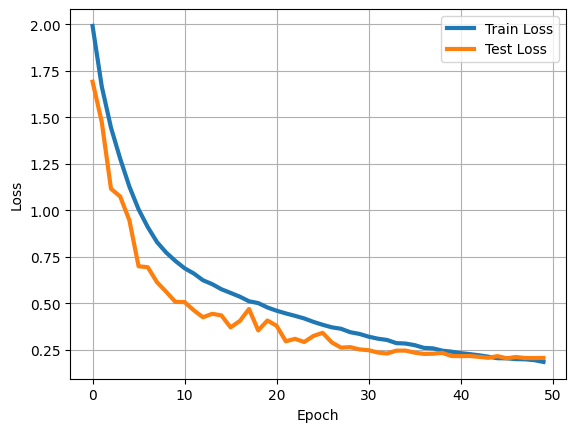

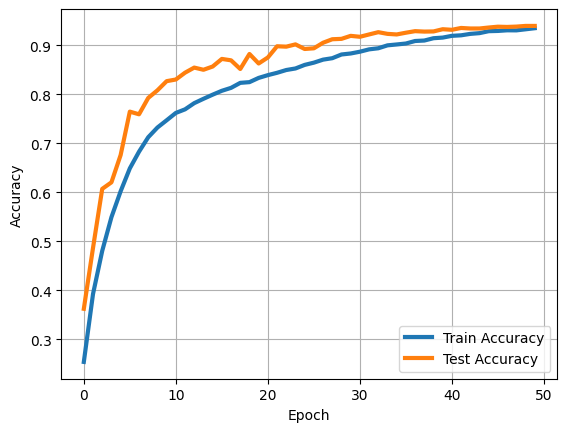

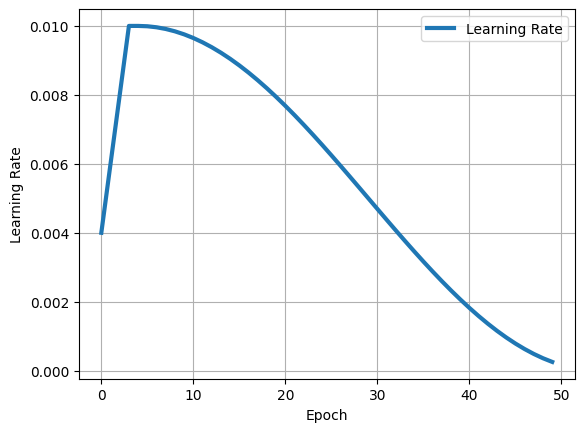

In [26]:
# Step 9.2: Execution for Training the ResNet model and Generating Test Data Accuracy

decay_factor = 0.7

model_for_test = assemble_resnet_model().cuda()
summary(model_for_test, (3, 32, 32))               # Visualize the model structure

train_final_phase(
    model_for_test,
    full_train_loader,
    test_data_loader,
    train_batch_size,
    resnet_channels,
    total_epochs,
    base_lr,
    decay_factor,
    weight_decay_factor,
    lr_decay_step,
    momentum_factor
)



# 10 **Find the Best Performance Model through Test Accuracy**


*   Get the top test accuracy model through model .pt file
*   Produce the Test Accuracy result based on this model

-------------------------------------------------
Best Model Saved       Test loss        Test acc
-------------------------------------------------
     Best model         0.20615         0.93928
-------------------------------------------------

torch.return_types.max(
values=tensor([20.2541,  5.4153,  8.2241, 11.3539, 21.0671,  6.5276, 13.7546,  8.5614,
         9.0074, 12.6179, 15.6218, 10.1581,  6.5876, 16.5394, 13.8908, 23.5149],
       device='cuda:0'),
indices=tensor([7, 5, 8, 0, 8, 4, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0'))
tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5, 3, 8, 3, 5, 1, 7], device='cuda:0')
tensor(0.4470, device='cuda:0')


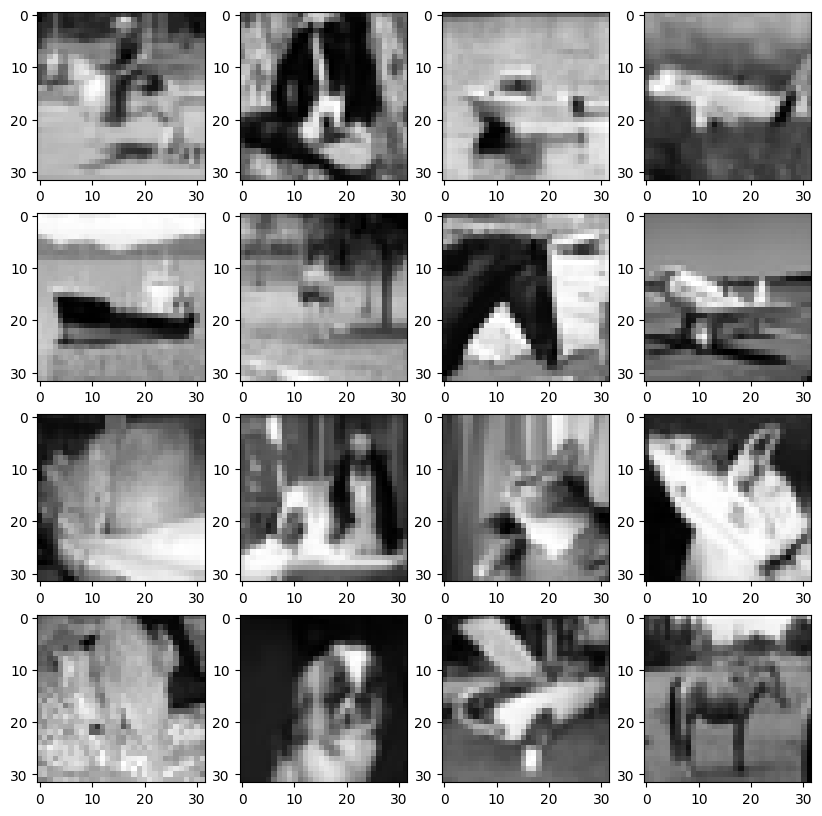

In [27]:
# Find the Best Performance Model through Test Accuracy


# 1) Find the most recently saved best model file
list_of_files = glob.glob('test_phase_model_saves/*')
latest_file = max(list_of_files, key=os.path.getctime)
# Parse the timestamp from the filename to locate the corresponding log file
start_time = latest_file.split('/')[-1].split('_model.pt')[0]

# 2) Open the corresponding log file (append mode)
log_file_path = "test_phase_log_records/" + start_time + ".txt"
f = open(log_file_path, 'a')

# 3) Prepare the device and load the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = assemble_resnet_model().to(device)

# Load the best model weights
model_path = 'test_phase_model_saves/' + start_time + '_model.pt'
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

# 4) Compute accuracy and loss on the test set
loss_fn = nn.CrossEntropyLoss()
test_loss = 0.0
test_acc = 0.0

model.eval()
for _, (images, labels) in enumerate(test_data_loader):
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        predicted_output = model(images)
        loss_val = loss_fn(predicted_output, labels)
        test_loss += loss_val.item()

        _, pred_class = predicted_output.max(1)
        correct_count = (pred_class == labels).sum().item()
        test_acc += correct_count / images.size(0)

test_loss = test_loss / len(test_data_loader)
test_acc = test_acc / len(test_data_loader)
epoch_end_time = datetime.datetime.now()

# 5) Print test results
print("-------------------------------------------------")
line_header = "{:>15} {:>15} {:>15}".format("Best Model Saved", "Test loss", "Test acc")
print(line_header)
print("-------------------------------------------------")
line_value = "{:>15} {:>15} {:>15}".format("Best model", round(test_loss, 5), round(test_acc, 5))
print(line_value)
print("-------------------------------------------------\n")
# 6) Write results to the log
f.write('For the best model, Test loss %.6f, Test acc %.6f\n' % (test_loss, test_acc))

# 7) Visualize output: Print prediction information of the last batch
print(torch.max(predicted_output, 1))
f.write(str(torch.max(predicted_output, 1)) + '\n')
print(labels)
f.write(str(labels) + '\n')
print(loss_val)
f.write(str(loss_val) + '\n')

# 8) Simply visualize the first 16 images of the last batch
plt.figure(figsize=(10,10))
for idx in np.arange(0, 16):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(images[idx].cpu()[0,:,:].squeeze(), cmap=plt.cm.gray)
plt.savefig('test_phase_log_records/' + str(start_time) + '_test_instances.png')

f.close()


11

In [30]:
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

###############################################
# 1) Read the dictionary, check its keys, and extract images and IDs
###############################################
with open("cifar_test_nolabel.pkl", "rb") as f:
    test_dict = pickle.load(f)
    print("Type of test_dict:", type(test_dict))      # <class 'dict'>
    print("Keys in test_dict:", test_dict.keys())     # dict_keys([b'data', b'ids'])

# Extract image data and image IDs
test_images = test_dict[b'data']
test_ids = test_dict[b'ids']

print("Shape of test_images:", test_images.shape)
print("Length of test_ids:", len(test_ids))

###############################################
# 2) Customize Dataset for unlabeled data inference
###############################################
class CifarNoLabelDataset(Dataset):

    def __init__(self, data_array, transform=None):
        self.data = data_array
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]  # Extract the idx-th image

        if self.transform:
            img = self.transform(img)
        return img

###############################################
# 3) Define transforms for inference
###############################################
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2471, 0.2435, 0.2616))
])

test_dataset = CifarNoLabelDataset(test_images, transform=transform_pipeline)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

###############################################
# 4) Load the best model and weights
###############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = assemble_resnet_model().to(device)
model_path = "/content/test_phase_model_saves/best_model.pt"  # Working path of the saved best model weights file
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

###############################################
# 5) Perform inference on unlabeled data
###############################################
predictions = []
with torch.no_grad():
    for batch_imgs in test_loader:
        batch_imgs = batch_imgs.to(device)
        outputs = model(batch_imgs)
        _, predicted_classes = outputs.max(1)
        predictions.extend(predicted_classes.cpu().numpy())

###############################################
# 6) Generate submission.csv
#    - ID comes from test_ids
#    - Labels come from predictions
###############################################

submission_df = pd.DataFrame({
    "ID": test_ids,
    "Labels": predictions
})

submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' generated successfully!")



Type of test_dict: <class 'dict'>
Keys in test_dict: dict_keys([b'data', b'ids'])
Shape of test_images: (10000, 32, 32, 3)
Length of test_ids: 10000
Submission file 'submission.csv' generated successfully!


In [31]:
import pickle

with open("cifar_test_nolabel.pkl", "rb") as f:
    test_dict = pickle.load(f)

print("Type of test_dict:", type(test_dict))
print("Keys in test_dict:", test_dict.keys())


Type of test_dict: <class 'dict'>
Keys in test_dict: dict_keys([b'data', b'ids'])
